# FEM -Example


## 0.0 Introduction
This notebook shows you how to preform a Fluctuation Electron Mircoscopy (FEM) analysis for a Zr-Cu-Al Sample.  Most of this analysis is done in [pyXEM](https://github.com/pyxem/pyxem) version 13.3. As a package in development there might be some breaking changes with each sucessive itereation.  pyxXEM is an extension of [hyperspy](https://hyperspy.org/hyperspy-doc/current/index.html) so reading some of their documentation is a good place to start in many cases. 

In this notebook we will focus on calculating $V_\Omega$ which can be defined as follows.  The first part describes the varience while the second part describes the possion noise correction.

Equation 1:   $V_\Omega = \frac{<<I>_\theta^2 >_r}{<<I>_{\theta, r}>^2 } -1 - \frac{gain}{<\Sigma_\theta(I)>_r}$

In [1]:
import numpy as np
import hyperspy.api as hs
import glob
from skimage.measure import EllipseModel
from hyperspy.signal import BaseSignal
import matplotlib.pyplot as plt

## 1.0 Loading and Visualizing the Data 

The example data is a 10x10 STEM dataset with large spacing betweent the probe positions. A HAADF image is also included to use as a reference for the thickness filtering.

The data is currently in the `.hspy` format which is hyperspy's open hdf5 file format.  Hyperspy can load many different file types, however, a complete list is given [here](https://hyperspy.org/hyperspy-doc/current/user_guide/io.html#supported-formats)

In [2]:
signals = glob.glob('Data/*')

In [3]:
signals

['Data/pos5-1.hdf5',
 'Data/pos1-1.hdf5',
 'Data/pos4-2.hdf5',
 'Data/pos1-2.hdf5',
 'Data/pos4-1.hdf5',
 'Data/pos6-1.hdf5',
 'Data/pos5-2.hdf5',
 'Data/pos3-2.hdf5',
 'Data/pos6-2.hdf5',
 'Data/pos3-1.hdf5']

In [4]:
signal = hs.load(signals[0], signal_type="electron_diffraction")

/srv/home/csfrancis/hyperspy/hyperspy/misc/utils.py:470: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/srv/home/csfrancis/hyperspy/hyperspy/io.py:517: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [5]:
# here we can see information about the size of the set of diffraction patterns. 
signal

<ElectronDiffraction2D, title: , dimensions: (10, 10|512, 512)>

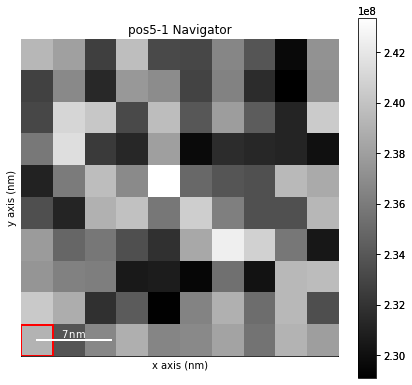

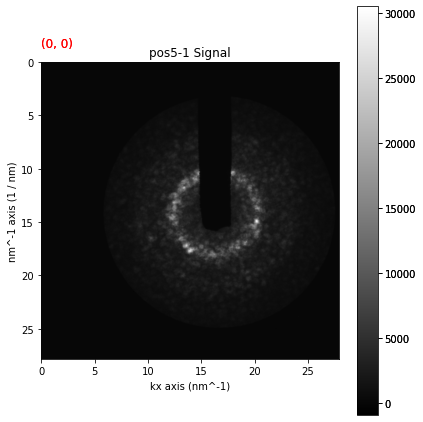

In [6]:
# change the plotting backend to make it intereactive
%matplotlib inline
signal.plot()

## 2.0 Calibrating the Diffraction Patterns

The following methods below are some methods useful for determing the center of some diffraction pattern if there is a beam stop included in the data.  The intent is to include these methods into pyxem (see https://github.com/pyxem/pyxem/pull/769) but they currently are not included.  If you don't have a beam stop I would recommend using the [`diffraction_signal.center_direct_beam()`](https://github.com/pyxem/pyxem/blob/de140bb5dc19c0e9d1a91a725c656c2bd2c056d0/pyxem/signals/diffraction2d.py#L698) method.

The method below also provides some ability to correct for ellipticty in the diffraction pattern. 

In general the best way to see if there is any ellipticity in a diffraction pattern is to look at the polar unwrapped diffraction pattern which we have done below. 

In [7]:
def get_max_positions(signal,
                      mask=None,
                      num_points=5000,
                      ):
    """ Gets the top num_points pixels in the dataset.

    Parameters
    --------------
    signal: BaseSignal
        The signal which we want to find the max positions for.
    mask: np.array
        A mask to be applied to the data for values to ignore
    num_points: int
        The number of points to be
    """
    if isinstance(signal, BaseSignal):
        data = signal.data
    else:
        data = signal
    i_shape = np.shape(data)
    flattened_array = data.flatten()
    if mask is not None:
        flattened_mask = mask.flatten()
        flattened_array[flattened_mask]=0
    # take top 5000 points make sure exclude zero beam
    indexes = np.argsort(flattened_array)
    cords = np.array([np.floor_divide(indexes[-num_points:], i_shape[1]),
             np.remainder(indexes[-num_points:], i_shape[1])]) # [x axis (row),y axis (col)]
    return cords.T

def determine_ellipse(signal,
                      mask=None,
                      num_points=1000,
                      **kwargs,
                      ):
    """
    This method starts by taking some number of points which are the most intense
    in the signal.  It then takes those points and guesses some starting parameters
    for the `get_ellipse_model_ransac_single_frame` function. From there it will try
    to determine the ellipse parameters.

    Parameters
    -----------
    signal: Signal2D
        The signal of interest
    mask: Array-like
        The mask to be applied to the data.  All of the masked values are ignored
    num_points: int
        The number of points to consider
    guess_starting_params: bool
        If True then the starting parameters will be guessed based on the points determined.
    **kwargs:
        Any other keywords for ` get_ellipse_model_ransac_single_frame`

    Returns
    -------
    center: (x,y)
        The center of the diffraction pattern
    affine:
        The affine transformation to make the diffraction pattern circular.
    """
    pos = get_max_positions(signal,
                            mask=mask,
                            num_points=num_points)
    e = EllipseModel()
    converge = e.estimate(data=pos)
    el = e
    if el is not None:
        affine = ellipse_to_affine(el.params[3],el.params[2], el.params[4])
        center = (el.params[0],el.params[1])
        return center, affine
    else:
        print("Ransac Ellipse detection did not converge")
        return None

def ellipse_to_affine(major, minor, rot):
    if major < minor:
        print("major<minor")
        temp = major
        major = minor
        minor = temp
        rot=rot+(np.pi/2)

    Q = [[np.cos(rot), -np.sin(rot), 0],
         [np.sin(rot), np.cos(rot), 0],
         [0, 0, 1]]
    S = [[1, 0, 0],
         [0, major / minor, 0],
         [0, 0, 1]]
    C = np.matmul(np.matmul(Q, S), np.transpose(Q))
    return C

In [8]:
center, affine =determine_ellipse(signal.sum())
plt.show()

In [9]:
signal.beam_energy=200
signal.unit="k_nm^-1"
signal.set_ai(center= center)

  0%|          | 0/100 [00:00<?, ?it/s]

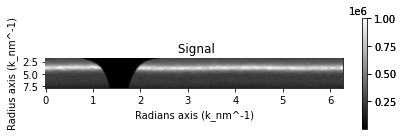

In [10]:
signal.get_azimuthal_integral2d(npt=100).sum().isig[:,2.:8.].plot()

## 3.0 Calculating the Variance

From this point calcualating the variance is quite easy.  The `get_varaince` method can easily calculate the variance using the Azimuthal_Integrator set above with the `set_ai` method. 

Note that the DQE parameter isn't really the best description for that parameter.  A more accureate description is the gain of the detector.  It is used to count the number of electrons which hit the detector.  That is then used for the Possion Noise Correction.

In [11]:
help(signal.get_variance)

Help on method get_variance in module pyxem.signals.diffraction2d:

get_variance(npt, method='Omega', dqe=None, spatial=False, navigation_axes=None, **kwargs) method of pyxem.signals.electron_diffraction2d.ElectronDiffraction2D instance
    Calculates the variance using one of the methods described in [1]. A shot noise correction and
       and specification of axes to operate over are also possible.
    
    Parameters
    ----------
    npt : int
        The number of points to use in the azimuthal integration
    method : 'Omega' or 'r' or 're' or 'VImage', optional
        The method used to calculate the variance. Details in [1]
    dqe : int, optional
        The detector quantum efficiency or the pixel value for one electron.
    spatial : bool, optional
        Included intermediate spatial variance in output (only avaliable if method=='r')
    navigation_axes : list or none, optional
        The axes to calculate the variance over.  The default is to use the navigation axes.
 

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


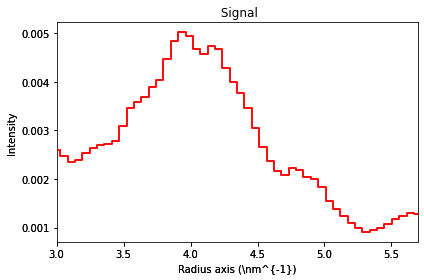

In [12]:
signal.get_variance(npt=50,dqe=4.2, radial_range=(3.0,5.75)).plot()

## 4.0 Thickness Filtering 

Another consideration is often the thickness of the sample.  For this sample (which is deposited as a thin film) variations of thickness are minimal.  For samples which have much more variation of thickness, the $V_\Omega$ calculcation will mostly just measure the variations due to thickness rather than strucuture. 

As $V_\Omega$ measures spatial variance it is very sensitive to thickness changes in the sample. 

Thickness filtering is not currently built into `pyxem` but preforming some thickness filtering isn't terrribly difficult using the framework available. 

In [13]:
# We have already saved the haadf along side the dataset. We can see this here...
signal.metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── Camera
│       │       └── exposure = 0.000003
│       ├── Stage
│       │   ├── tilt_alpha = 0.0
│       │   ├── tilt_beta = 0.0
│       │   ├── x = 0.5984470000000001
│       │   ├── y = -0.24668500000000002
│       │   └── z = 0.133236
│       ├── acquisition_mode = STEM
│       ├── beam_energy = 200
│       ├── camera_length = 510.0
│       ├── magnification = 1300000.0
│       ├── microscope = Titan 300 kV D2080 SuperTwin
│       ├── probe_area = 3.141592653589793
│       ├── probe_resolution = 2.0
│       └── probe_step = 3.0
├── General
│   ├── authors = SUPERVISOR
│   ├── date = 2018-03-28
│   ├── original_filename = pos5-1_1.ser
│   ├── time = 14:46:49
│   └── title = 
├── HAADF
│   ├── filter_intercept = -35.0
│   ├── filter_slope = 0.00221729
│   └── intensity = array([[33838., 33760., 33824., 34052., 33760., 33732., 34047., 33998.,
       ... 44., 34103., 33980., 33871., 33924., 33756., 33906.,
        34071., 34200.]])
├── Sample
│   └── deposition_rate = 0.24
├── Signal
│   ├── Ellipticity
│   │   └── calibrated = False
│   ├── ai = Detector Detector	 Spline= None	 PixelSize= 1.367e-04, 1.367e-04 m
Wavelength= ... m	Center: x=299.979, y=260.892 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
│   ├── signal_type = electron_diffraction
│   └── type = diffraction_signal
├── convergence_angle = 0.74
└── original_filename = pos5-1.

In [14]:
haadf = hs.signals.Signal2D(signal.metadata.HAADF.intensity)

In [15]:
thickness = ((haadf -26265)/440.46)

In [16]:
def thickness_filter(signal, thickness, bins):
    masks = [np.logical_and(bins[i]<thickness, bins[i+1]>thickness) for i in range(len(bins)-1)]
    filtered = [hs.signals.Signal2D(signal.data[m.data,:,:]) for m in masks]
    for f in filtered:
        f.set_signal_type("electron_diffraction")
        f.axes_manager.signal_axes= signal.axes_manager.signal_axes
        f.metadata = signal.metadata
    return filtered, thickness

In [17]:
bins = np.linspace(np.min(thickness, axis=(0,1)), np.max(thickness, axis=(0,1)), num=2+1)
filtered, thickness = thickness_filter(signal, thickness, bins)

In [18]:
var = [f.get_variance(npt=50, dqe=4.2, radial_range=(3.0, 5.7)) for f in filtered]

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s


<AxesSubplot:xlabel='Radius (\\nm^{-1})', ylabel='Intensity'>

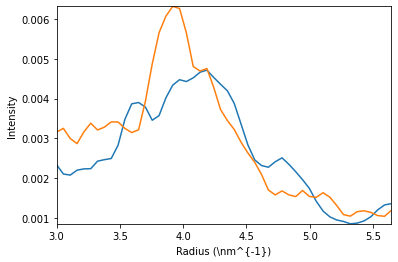

In [19]:
hs.plot.plot_spectra(var)

## Further Example 
## (WARNING! This might not work in Binder because of Memory Constraints)

In this case we don't have quite enough data to accurately measure the stucuture of the sample.  100 diffraction patterns split into different thicknesses isn't quite statistically rigorous.  Ideally the variance curves would be identical for each thickness. Simply we just don't have enough data to calculate what we are interested in calculating.


Below we have loaded 10 seperate positions each with a 10x10 dataset collected.  This is starting to get to enough data to run one of these experiments.  That being said, if you have a sample with a lot of thickness variation then you will need to probe a larger area. 

In [20]:
signals = glob.glob('Data/*')
signals = hs.load(signals, signal_type="electron_diffraction")

/srv/home/csfrancis/hyperspy/hyperspy/misc/utils.py:470: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn('Use of the `binned` attribute in metadata is '
/srv/home/csfrancis/hyperspy/hyperspy/io.py:517: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [21]:
for s in signals:
    center, affine =determine_ellipse(s.sum())
    s.beam_energy=200
    s.unit="k_nm^-1"
    s.set_ai(center= center)
    haadf = hs.signals.Signal2D(s.metadata.HAADF.intensity)

major<minor
major<minor
major<minor
major<minor


In [22]:
var = [s.get_variance(npt=50, dqe=4.2, radial_range=(3.0, 5.7) )for s in signals]

[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.6s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s


/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

[(3.0, 5.7), Text(0, 0.5, 'Variance'), Text(0.5, 0, 'k, nm $^{-1}$')]

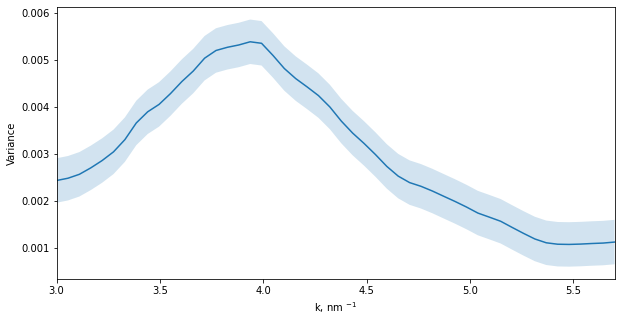

In [23]:
fig, axs =plt.subplots(1,1,figsize=(10,5))

error = np.std([v.data for v in var])/np.sqrt(10)
mean_val = np.mean(var).data
axs.plot(np.linspace(3.0,5.7,50), mean_val)
axs.fill_between(np.linspace(3.0,5.7,50),mean_val-error, mean_val+error, alpha=.2)
axs.set(xlim=(3.0,5.7), ylabel="Variance", xlabel="k, nm $^{-1}$")


## Different Methods for Calculating Variance


Additional methods for calculating varaince are also available.  The naming standard follows the 2010 Kelton paper[1]

    [1] Daulton, T. L et al, Ultramicroscopy, 110(10), 1279–1289, https://doi.org/10.1016/j.ultramic.2010.05.010
        Nanobeam diffraction fluctuation electron microscopy technique for structural characterization of disordered
        materials-Application to Al88-xY7Fe5Tix metallic glasses.

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[########################################] | 100

/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[                                        ] | 0% Completed |  0.0s

/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  0.5s
[                                        ] | 0% Completed |  0.0s

[########################################] | 100% Completed |  0.6s
[########################################] | 100% Completed |  0.5s


/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: FutureWarning: The input object of type 'ElectronDiffraction1D' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'ElectronDiffraction1D', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return array(a, dtype, copy=False, order=order, subok=True)
/srv/home/csfrancis/miniconda3/envs/developmental/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' whe

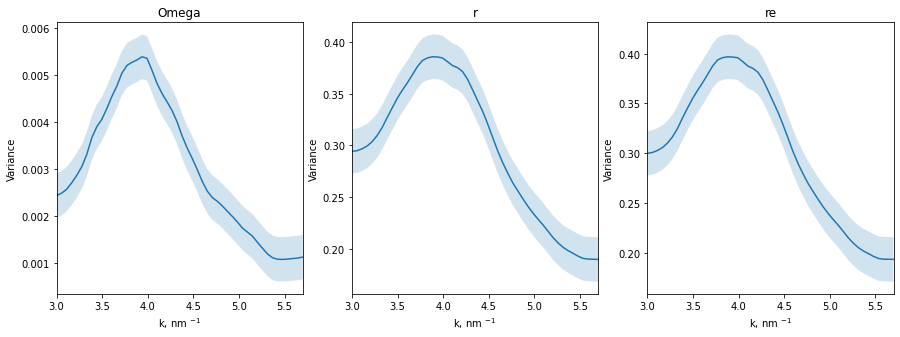

In [24]:
fig, axs =plt.subplots(1,3,figsize=(15,5))
gain=4.2
for method,ax in zip(["Omega", "r", "re"],axs):
    var = [s.get_variance(npt=50, dqe=gain, radial_range=(3.0, 5.7), method=method)for s in signals]
    error = np.std([v.data for v in var])/np.sqrt(10)
    mean_val = np.mean(var).data
    ax.plot(np.linspace(3.0,5.7,50), mean_val)
    ax.fill_between(np.linspace(3.0,5.7,50),mean_val-error, mean_val+error, alpha=.2)
    ax.set(xlim=(3.0,5.7), ylabel="Variance", xlabel="k, nm $^{-1}$")
    ax.title.set_text(method)
